# Integrating Photoacoustic operations with automatic differention in Flux. 

In this tutorial, we will illustrate how to combine the operators of Photoacoustic.jl with the AD system used in Flux.jl. Our illustration will be a photoacoustic inverse problem where the observe data has been generated by a photoacoustic operator
$y = Ax$. We want to solve this inverse problem in the least squares sense:
$$\mathrm{argmin}_{x} \, \|Ax - y\|_2^2$$

In the framework of deep prior, we parameterize the unknown $x$ as the output of an untrained neural network $G_{\theta}(z)$ and optimize over its learnable parameters. 

$$\mathrm{argmin}_{\theta} \, \|AG_{\theta}(z) - y\|_2^2$$

Here is the key: if we want to solve this variational problem we need to "chain" the derivatives of the learned network (derivatives come from Zygote AD system) with the derivate of the photoacoustic operator (hand derived in Photoacoustic.jl). In this tutorial we demonstrate how this is easily done with the ChainRules.jl framework. 

In [1]:
using PhotoAcoustic
using JUDI
using Flux
using ProgressMeter: Progress, next!
using MLDatasets
using PyPlot
using ChainRulesCore
using Statistics
using LinearAlgebra
using Images

┌ Info: Precompiling PhotoAcoustic [86b14aa7-fcb7-4836-b4c7-056f45a9c77b]
└ @ Base loading.jl:1662


## Define a neural network

In [2]:
struct UNet
    layers::NamedTuple
end

In [3]:
"""
User Facing API for UNet architecture.
"""
function UNet(channels=[32, 64, 128, 256])
    return UNet((
        # Encoding
        conv1=Conv((3, 3), 1 => channels[1], stride=1, bias=false),
        gnorm1=GroupNorm(channels[1], 4, swish),
            
        conv2=Conv((3, 3), channels[1] => channels[2], stride=2, bias=false),
        gnorm2=GroupNorm(channels[2], 32, swish),
            
        conv3=Conv((3, 3), channels[2] => channels[3], stride=2, bias=false),
        gnorm3=GroupNorm(channels[3], 32, swish),
            
        conv4=Conv((3, 3), channels[3] => channels[4], stride=2, bias=false),
        gnorm4=GroupNorm(channels[4], 32, swish),
            
        # Decoding
        tconv4=ConvTranspose((3, 3), channels[4] => channels[3], stride=2, bias=false),
        tgnorm4=GroupNorm(channels[3], 32, swish),
            
        tconv3=ConvTranspose((3, 3), channels[3] + channels[3] => channels[2], pad=(0, -1, 0, -1), stride=2, bias=false),
        tgnorm3=GroupNorm(channels[2], 32, swish),
            
        tconv2=ConvTranspose((3, 3), channels[2] + channels[2] => channels[1], pad=(0, -1, 0, -1), stride=2, bias=false),
        tgnorm2=GroupNorm(channels[1], 32, swish),
            
        tconv1=ConvTranspose((3, 3), channels[1] + channels[1] => 1, stride=1, bias=false),
    ))
end

Flux.@functor UNet

In [4]:
expand_dims(x::AbstractVecOrMat, dims::Int=2) = reshape(x, (ntuple(i -> 1, dims)..., size(x)...))
expand_dims_rev(x::AbstractVecOrMat, dims::Int=2) = reshape(x,  size(x)...,(ntuple(i -> 1, dims)...))

expand_dims_rev (generic function with 2 methods)

In [5]:
function (unet::UNet)(x)

    # Encoder
    h1 = unet.layers.conv1(x)
    h1 = unet.layers.gnorm1(h1)
    
    h2 = unet.layers.conv2(h1)
    h2 = unet.layers.gnorm2(h2)
    
    h3 = unet.layers.conv3(h2)
    h3 = unet.layers.gnorm3(h3)
    
    h4 = unet.layers.conv4(h3)
    h4 = unet.layers.gnorm4(h4)
    
    # Decoder
    h = unet.layers.tconv4(h4)
    h = unet.layers.tgnorm4(h)
    
    h = unet.layers.tconv3(cat(h, h3; dims=3))
    h = unet.layers.tgnorm3(h)
    
    h = unet.layers.tconv2(cat(h, h2, dims=3))
    h = unet.layers.tgnorm2(h)
    
    h = unet.layers.tconv1(cat(h, h1, dims=3))
end

# Define photoacoustic simulation

In [6]:
# Set up model structure
n = (68, 68)   # (x,y,z) or (x,z)
d = (0.08f0, 0.08f0)
o = (0., 0.)

# Constant water velocity [mm/microsec]
v = 1.5*ones(Float32,n) 
m = (1f0 ./ v).^2

# Setup model structure
model = Model(n, d, o, m;)

# Set up receiver geometry
nxrec = 64
xrec = range(0, stop=d[1]*(n[1]-1), length=nxrec)
yrec = [0f0]
zrec = range(0, stop=0, length=nxrec)

# receiver sampling and recording time
time = 5.2333 #[microsec] 
dt = calculate_dt(model) / 2    

# Set up receiver structure
recGeometry = Geometry(xrec, yrec, zrec; dt=dt, t=time, nsrc=1)

# Setup operators
opt = Options(dt_comp=dt)
F = judiModeling(model; options=opt)
A = judiPhoto(F, recGeometry;)

JUDI forward{Float32} propagator (z * x) -> (src * rec * time)

## Get model x

In [7]:
xtrain, ytrain = MNIST.traindata(Float32)
x = judiInitialState(imresize(xtrain[:,:,1], (n[1], n[2])))

judiInitialState{Float32} with 1 sources


# Make observed data 

Building forward operator
Operator `forward` ran in 0.01 s


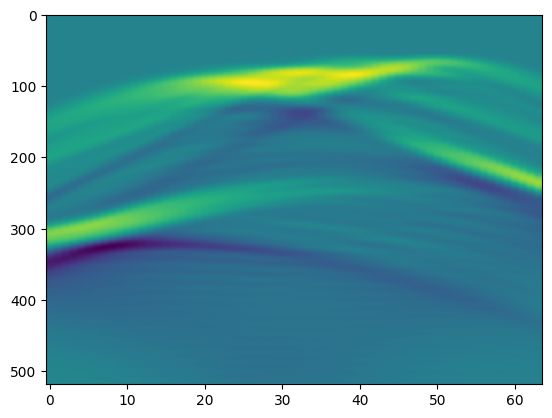

PyObject <matplotlib.image.AxesImage object at 0x2b4df58e0>

In [8]:
y = A*x
imshow(y.data[1];aspect="auto")

## Add rrule for chainfules to know how to differentiate the photoacoustic operator

In [9]:
function ChainRulesCore.rrule(::typeof(*), A::T, x) where {T<:judiPhoto}
    y = A*judiInitialState(x)
    pullback(Δy) = (NoTangent(), NoTangent(), expand_dims_rev((A'*Δy).data[1]))
    return y, pullback
end


In [10]:
function model_loss(A, model, y, z)
    norm(A*model(z) - y).^2
end

model_loss (generic function with 1 method)

## Training Hyperparameters 

In [11]:
device = cpu          # only works on cpu right now
lr = 5e-3             # learning rate
epochs = 200           # number of epochs

200

In [12]:
# initialize UNet model
unet = UNet() |> device

# initialize input to model. This is not a trainable parameter 
z = randn(Float32, n[1], n[1], 1, 1) |> device

# ADAM optimizer
opt = ADAM(lr)

# trainable parameters
ps = Flux.params(unet);

## Training

In [13]:
loss_log = []
error_log = []
progress = Progress(epochs)

for epoch = 1:epochs    
    loss, grad = Flux.withgradient(ps) do
        model_loss(A, unet, y, z)
    end
    Flux.Optimise.update!(opt, ps, grad)
    
    append!(loss_log, loss)
    append!(error_log, norm(unet(z)[:,:,1,1]' - x.data[1][:,:,1,1]')^2)
    
    # progress meter
    next!(progress; showvalues=[(:loss, loss)])
end

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter /Users/mathiaslouboutin/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
  loss:  0.011968669


## Show training log

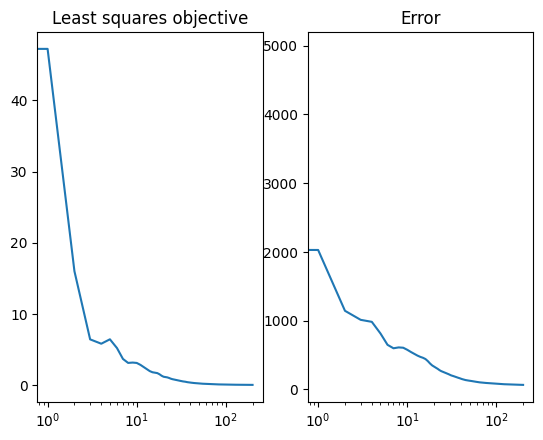

In [18]:
subplot(1,2,1); title("Least squares objective")
semilogx(loss_log; );
subplot(1,2,2);title("Error")
semilogx(error_log; );

## Plot our results

Operator `forward` ran in 0.01 s
Operator `forward` ran in 0.01 s


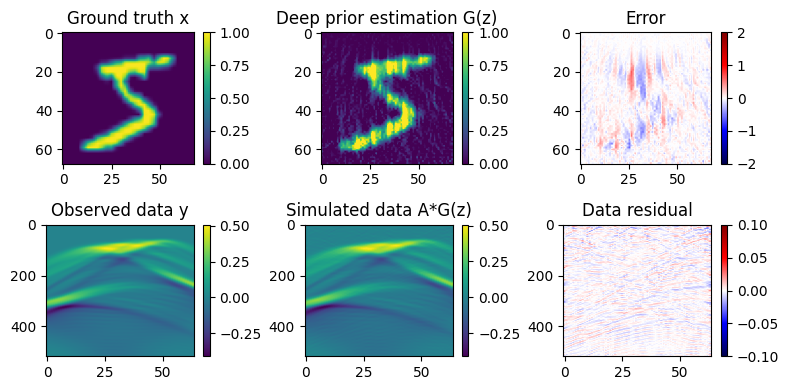

In [15]:
fig = figure(figsize=(8,4))
subplot(2,3,1); title("Ground truth x")
imshow(x.data[1][:,:,1,1]'; vmin=0,vmax = 1); colorbar()
subplot(2,3,2); title("Deep prior estimation G(z)")
imshow(unet(z)[:,:,1,1]'; vmin=0,vmax = 1); colorbar() 
subplot(2,3,3); title("Error")
imshow(unet(z)[:,:,1,1]' - x.data[1][:,:,1,1]'; cmap = "seismic", vmin=-2, vmax = 2); colorbar()

subplot(2,3,4); title("Observed data y")
imshow(y.data[1];aspect="auto"); colorbar()
subplot(2,3,5); title("Simulated data A*G(z)")
imshow((A*judiInitialState(unet(z))).data[1];aspect="auto"); colorbar() 
subplot(2,3,6); title("Data residual")
imshow((A*judiInitialState(unet(z))).data[1] - y.data[1];aspect="auto",cmap = "seismic", vmin=-0.1, vmax = 0.1);  colorbar() 

tight_layout()